In [ ]:
# this doesn't play well

In [ ]:
# This code creates a function that calculates ccf while dealing with NaNs
# Define a function to obtain the cross-correlation (ccf) between timeseries
# Length determines how many seconds forward/backward the ccf considered
def obtain_ccf(ts_1, ts_2, length=5):
    # Reverse the time series: used to calculate the cross-correlation from end of the series toward beginning
    # Explores how past values of ts_2 influence future values of ts_1
    # Use the direct method in convolve to handle NaN or inf values
    # [::-1] reverses the result again; restores chronological order of lags
    # [-(length*256+1):] slices the array to keep the last length*256+1 elements, based on sampling rate
    backward_full = convolve(ts_1[::-1], ts_2[::-1], mode='full', method='direct')
    backwards = backward_full[::-1][-(length*256+1):]

    # Computes the forward cross-correlation function
    # Explores how past values of ts_1 influence future values of ts_2
    forwards_full = convolve(ts_1, ts_2, mode='full', method='direct')
    forwards = forwards_full[:(length*256+1)]

    # Remove NaN values from forwards and backwards (need this for correlation calculation, below)
    clean_backwards = backwards[~np.isnan(backwards)]
    clean_forwards = forwards[~np.isnan(forwards)]

    # Concatenate result arrays along the first axis (row-wise)
    ccf_output = np.r_[clean_backwards[:-1], clean_forwards]
    return ccf_output

In [1]:
# Load dependencies

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.tsa.stattools as smt
from scipy.signal import convolve
from scipy.stats import pearsonr, zscore
from matplotlib import pyplot as plt

In [2]:
# Read in the cleaned long eeg data
# Update filename based on epoch duration

eeg_long_df = pd.read_csv("preprocessed_interpolate_bandpass_.1_20/eeg_long_df_1s_epoch.csv")

# Print how long the df is
len(eeg_long_df)

32646912

In [3]:
eeg_long_df.shape

(32646912, 14)

In [4]:
eeg_long_df

,level_0,index,epoch,time,TP9-1,AF7-1,AF8-1,TP10-1,TP9-2,AF7-2,AF8-2,TP10-2,subj,ses
0,0,0,0,0.000000,0.222848,11.608067,0.223902,0.058120,-0.483754,-5.345793,-0.345295,-0.346974,1,1
1,1,1,0,0.003906,-1.673274,-25.432445,-2.610390,0.434157,2.526975,151.898427,2.187296,-2.175046,1,1
2,2,2,0,0.007812,-3.492170,-54.826924,-4.886415,0.673630,4.259710,290.713836,4.544382,-4.696435,1,1
3,3,3,0,0.011719,-5.221177,-70.724021,-6.137424,0.643151,3.749553,396.613306,6.575249,-8.378026,1,1
4,4,4,0,0.015625,-6.957718,-70.413833,-6.059825,0.200740,0.575384,462.006339,8.172946,-13.309297,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32646907,75003,53755,292,0.980469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3
32646908,75004,53756,292,0.984375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3
32646909,75005,53757,292,0.988281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3
32646910,75006,53758,292,0.992188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3


In [5]:
# For rejected epochs, autoreject replaces that value with a zero
# This code replaces zero wit nan to deal with that issue

#eeg_long_df[["TP9-1", "AF7-1", "AF8-1", "TP10-1", "TP9-2", "AF7-2", "AF8-2", "TP10-2"]] = \
#eeg_long_df.loc[:, ["TP9-1", "AF7-1", "AF8-1", "TP10-1", "TP9-2", "AF7-2", "AF8-2", "TP10-2"]].replace(0, np.nan)

In [6]:
eeg_long_df

,level_0,index,epoch,time,TP9-1,AF7-1,AF8-1,TP10-1,TP9-2,AF7-2,AF8-2,TP10-2,subj,ses
0,0,0,0,0.000000,0.222848,11.608067,0.223902,0.058120,-0.483754,-5.345793,-0.345295,-0.346974,1,1
1,1,1,0,0.003906,-1.673274,-25.432445,-2.610390,0.434157,2.526975,151.898427,2.187296,-2.175046,1,1
2,2,2,0,0.007812,-3.492170,-54.826924,-4.886415,0.673630,4.259710,290.713836,4.544382,-4.696435,1,1
3,3,3,0,0.011719,-5.221177,-70.724021,-6.137424,0.643151,3.749553,396.613306,6.575249,-8.378026,1,1
4,4,4,0,0.015625,-6.957718,-70.413833,-6.059825,0.200740,0.575384,462.006339,8.172946,-13.309297,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32646907,75003,53755,292,0.980469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3
32646908,75004,53756,292,0.984375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3
32646909,75005,53757,292,0.988281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3
32646910,75006,53758,292,0.992188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3


In [7]:
# List-wise removal of NaNs because these prevent the ccf analysis from completing if they are included

#eeg_long_df = eeg_long_df.dropna()

In [8]:
#eeg_long_df.shape

In [9]:
# Read in task performance dat

performance = pd.read_csv("task_performance.csv")

In [10]:
# Set 'ses' column as integer

performance['ses'] = performance['ses'].astype(int)

In [11]:
# Merge 'performance' and 'eeg_long_df' on 'subj' and 'ses'

eeg_long_df = eeg_long_df.merge(performance[['subj', 'ses', 'Signal Drop']], on=['subj', 'ses'], how='left')

In [12]:
eeg_long_df

,level_0,index,epoch,time,TP9-1,AF7-1,AF8-1,TP10-1,TP9-2,AF7-2,AF8-2,TP10-2,subj,ses,Signal Drop
0,0,0,0,0.000000,0.222848,11.608067,0.223902,0.058120,-0.483754,-5.345793,-0.345295,-0.346974,1,1,1.0
1,1,1,0,0.003906,-1.673274,-25.432445,-2.610390,0.434157,2.526975,151.898427,2.187296,-2.175046,1,1,1.0
2,2,2,0,0.007812,-3.492170,-54.826924,-4.886415,0.673630,4.259710,290.713836,4.544382,-4.696435,1,1,1.0
3,3,3,0,0.011719,-5.221177,-70.724021,-6.137424,0.643151,3.749553,396.613306,6.575249,-8.378026,1,1,1.0
4,4,4,0,0.015625,-6.957718,-70.413833,-6.059825,0.200740,0.575384,462.006339,8.172946,-13.309297,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32646907,75003,53755,292,0.980469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3,0.0
32646908,75004,53756,292,0.984375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3,0.0
32646909,75005,53757,292,0.988281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3,0.0
32646910,75006,53758,292,0.992188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,181,3,0.0


In [13]:
# Filter out rows where 'Signal Drop' equals 1
# Note, this yields some NaNs in the signal drop column
# This is because performance has more observations than the eeg data
# this gets resolved, in code, later

eeg_long_df = eeg_long_df[eeg_long_df['Signal Drop'] != 1]

In [14]:
eeg_long_df

,level_0,index,epoch,time,TP9-1,AF7-1,AF8-1,TP10-1,TP9-2,AF7-2,AF8-2,TP10-2,subj,ses,Signal Drop
64768,0,0,0,0.000000,0.0,0.0,0.0,0.0,1.045445,3.490375,8.151611,0.937702,1,2,NaN
64769,1,1,0,0.003906,0.0,0.0,0.0,0.0,6.429343,-103.796619,-44.588396,6.704982,1,2,NaN
64770,2,2,0,0.007812,0.0,0.0,0.0,0.0,11.369235,-206.839112,-97.559567,11.973426,1,2,NaN
64771,3,3,0,0.011719,0.0,0.0,0.0,0.0,15.465029,-301.411454,-150.500839,16.291807,1,2,NaN
64772,4,4,0,0.015625,0.0,0.0,0.0,0.0,18.390014,-383.355473,-202.251699,19.303860,1,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32646907,75003,53755,292,0.980469,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,181,3,0.0
32646908,75004,53756,292,0.984375,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,181,3,0.0
32646909,75005,53757,292,0.988281,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,181,3,0.0
32646910,75006,53758,292,0.992188,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,181,3,0.0


In [15]:
# Create a group-by object by subject and session
# This means that each unique pair of subj and ses creates a separate group within this group-by object
# You need this to calculate the cross correlation function for each subject for each session, below

eeg_df_group = eeg_long_df.groupby(["subj", "ses"])

In [16]:
# Define a function to obtain the cross-correlation (ccf) between timeseries
# Length determines how many seconds forward/backward the ccf considered
# In this case, the time-series are shifted forward/bakward 5s

def obtain_ccf(ts_1, ts_2, length=5):
    # Reverse the time series: used to calculate the cross-correlation from end of the series toward beginning
    # Explores how past values of ts_2 influence future values of ts_1
    # adjusted=False: Do not adjust the scale of the correlation for the number of observations
    # This means that the ccf output is not normalized
    # [::-1] reverses the result again; restores chronological order of lags
    # [-(length*256+1):] slices the array to keep the last length*256+1 elements, based on sampling rate
    backwards = smt.ccf(ts_1[::-1], ts_2[::-1], adjusted=False)[::-1][-(length*256+1):]
    # Computes the forward cross-correlation function
    # Explores how past values of ts_1 influence future values of ts_2
    forwards = smt.ccf(ts_1, ts_2, adjusted=False)[:(length*256+1)]
    # Concatenate result arrays along the first axis (row-wise)
    ccf_output = np.r_[backwards[:-1], forwards]
    return ccf_output

In [17]:
# Initialize necessary dictionaries

ccf_dict = {}
ccf_dict["TP9"] = {}
ccf_dict["AF7"] = {}
ccf_dict["AF8"] = {}
ccf_dict["TP10"] = {}


# Initialize necessary list 

sessions_pair = []

# Calculate the cross correlation function for each subject for each session for each electrode
# Store results in relevant ccf dictionary
for name, group in eeg_df_group:
    if group.shape[0] >= 10*256+1: # Only process data is at least 10s long (sampling rate is 256Hz)
        ccf_dict["TP9"][name] = obtain_ccf(group["TP9-1"], group["TP9-2"])
        ccf_dict["AF7"][name] = obtain_ccf(group["AF7-1"], group["AF7-2"])
        ccf_dict["AF8"][name] = obtain_ccf(group["AF8-1"], group["AF8-2"])
        ccf_dict["TP10"][name] = obtain_ccf(group["TP10-1"], group["TP10-2"])
        
        # Add results to the sessions_pair list
        sessions_pair.append(name)

In [18]:
# This code sets number of dropped epochs and session length for subsequent filtering
# needs updated to match the criteria we use for the main analysis

#filtered_pairs = list(dropped_1[(dropped_1[0] <= 0.7) & 
#               (dropped_2[0] <= 0.7) & 
#               (session_size_1[0]/256/60 >= 3.5)][["subj", "ses"]].itertuples(index=False, name=None))

In [19]:
# This code applys
# needs updated to match the criteria we use for the main analysis

#sessions_pair_new = list(set(sessions_pair) & set(filtered_pairs))

In [20]:
# Convert each list directly into an array of objects
object_array = np.array([np.array(list(sublist.values()), dtype=object) for sublist in ccf_dict.values()])

print(object_array.shape)  # This will print (4, 5)


(4, 191, 2561)


In [21]:
# Create an array for all 4 electrodes, for all participants/sessions, for all time-shifted data (+/-5s)

ccf_matrix = np.array([list(ccf_dict["TP9"].values()),
list(ccf_dict["AF7"].values()),
list(ccf_dict["AF8"].values()),
list(ccf_dict["TP10"].values())])

# Check your work, should be 4 (electrodes) x 267 (number of participants*sessions) x 2561 (+/-5s + 0s offset)

ccf_matrix.shape

(4, 191, 2561)

In [22]:
# Create an index that will merge the number of subjects/sessions in the EEG data
# with the performance data (which has more subjects/sessions than the EEG data)

select_index = pd.DataFrame(sessions_pair)
select_index.columns = ["subj", "ses"]
select_index = select_index.sort_values(["subj", "ses"])

In [23]:
select_index

,subj,ses
0,1,2
1,2,3
2,3,2
3,3,3
4,5,3
...,...,...
186,178,3
187,179,1
188,179,2
189,181,2


In [24]:
# Reduce performance data as specified in the index above
# Make new dataframe of reduced data

performance_select = select_index.merge(performance, on=["subj", "ses"], how="left")
performance_select = performance_select.dropna().reset_index(drop=True)

In [25]:
performance_select

,subj,ses,Unnamed: 0,Performance,Time (sec),Signal Drop
0,2,3,4.0,10.0,552.0,0.0
1,3,2,6.0,7.0,294.0,0.0
2,3,3,7.0,7.0,262.0,0.0
3,5,3,11.0,7.0,303.0,0.0
4,6,2,12.0,3.0,428.0,0.0
...,...,...,...,...,...,...
152,178,3,297.0,8.0,207.0,0.0
153,179,1,298.0,11.0,671.0,0.0
154,179,2,299.0,11.0,556.0,0.0
155,181,2,305.0,7.0,426.0,0.0


In [26]:
# Convert "Performance" (correctly matched shapes) data into a NumPy array, store in the variable y

y = performance_select["Performance"].to_numpy()

In [27]:
y

array([10.,  7.,  7.,  7.,  3.,  0.,  7.,  9., 10.,  8.,  1.,  1.,  3.,
        0.,  4.,  7.,  1.,  7.,  5.,  7.,  2.,  6.,  0.,  6.,  6.,  5.,
        5.,  6., 11.,  5.,  4.,  2.,  2.,  7.,  7.,  0.,  3.,  4.,  7.,
       10.,  7.,  3.,  6.,  2.,  2.,  8.,  9.,  1.,  6.,  5.,  3.,  8.,
       11., 10.,  7., 11.,  6.,  4.,  3.,  5.,  9., 11.,  5.,  7.,  5.,
        7.,  7.,  2.,  0.,  9., 10., 11.,  7.,  1.,  1.,  0.,  5.,  2.,
        0., 10.,  2.,  5.,  7., 11.,  6.,  4.,  0.,  7.,  7.,  7.,  3.,
        5.,  5.,  8.,  1.,  0.,  2.,  5.,  7.,  2.,  4.,  9.,  7.,  5.,
        4.,  8.,  7.,  7., 11.,  4.,  7.,  8.,  0.,  1., 11., 10.,  8.,
        3., 11.,  7.,  7.,  6., 10.,  6.,  7., 10., 10.,  6.,  4.,  5.,
        3.,  8.,  2.,  6.,  7.,  7., 11.,  3.,  8.,  7.,  6., 11.,  5.,
        4.,  9.,  9.,  2., 10.,  7.,  7.,  9.,  9.,  8., 11., 11.,  7.,
       11.])

In [28]:
# Create a list where each element is a tuple containing: subject and session

final_select = list(performance_select[["subj", "ses"]].itertuples(index=False, name=None))

In [29]:
# Make temp_index that contains the indices of sessions_pair where its elements match those in final_select
# This will be used to index the ccf_matrix in the next code block

temp_index = []

for i in final_select:
    for j in range(len(sessions_pair)):
        if i == sessions_pair[j]:
            temp_index.append(j)

In [30]:
# Subset the ccf_matrix based on all entries in the first and third dimensions
# but only in the second dimension as specified by temp_index, and also in the ccf

X = ccf_matrix[:,temp_index,:]

In [31]:


# Initialize an empty dictionary
correlation_ccf = {}

# Specify channels and initialize an empty list for each channel
channels = ["TP9", "AF7", "AF8", "TP10"]
correlation_ccf["TP9"] = []
correlation_ccf["AF7"] = []
correlation_ccf["AF8"] = []
correlation_ccf["TP10"] = []

# Calculate pearson correlation coefficient
# Extract the ith element along the third dimension for the kth channel in ccf_matrix(X)
# Correlate with performance
for k in range(4):
    for i in range(X.shape[2]):
        correlation_ccf[channels[k]].append(pearsonr(X[k,:,i], y))

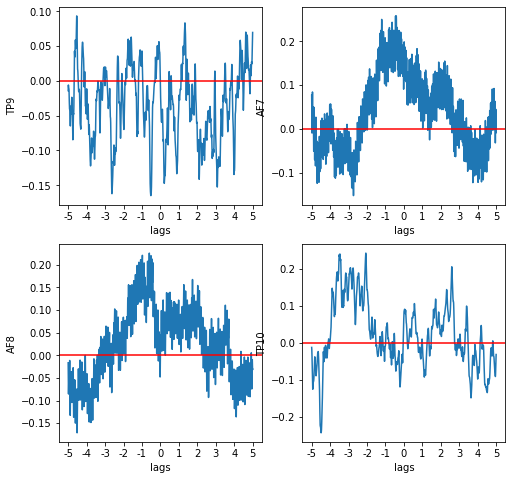

In [32]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

channels = ["TP9", "AF7", "AF8", "TP10"]
for i in range(4):
    axs[i//2, i%2].plot(np.array(correlation_ccf[channels[i]])[:,0])
    
    axs[i//2, i%2].set_xticks(np.linspace(0,2561, 11),
           np.round((np.linspace(0,2561, 11)-1281)/256,0).astype(int))
    axs[i//2, i%2].set_xlabel("lags")
    axs[i//2, i%2].set_ylabel(channels[i])
    axs[i//2, i%2].axhline(y=0, color='r', linestyle='-')
    
plt.show()

In [ ]:
t_lags = {}
channels = ["TP9", "AF7", "AF8", "TP10"]
t_lags["TP9"] = []
t_lags["AF7"] = []
t_lags["AF8"] = []
t_lags["TP10"] = []


for i in range(X.shape[2]):
    t_lags[channels[k]].append()

In [ ]:
X.shape

In [ ]:
def run_mreg_with_lag(X, y, lag):
    X_temp = X[:,:,lag].T
    X_with_const = sm.add_constant(X_temp)

    model = sm.OLS(y, X_with_const).fit()
    t_values = [i[3] for i in model.summary().tables[1].data[1:]]
    p_values = [i[4] for i in model.summary().tables[1].data[1:]]
    
    t_values = np.array(t_values).astype(float)
    p_values = np.array(p_values).astype(float)
    
    return (t_values, p_values)


In [ ]:
t_values_lags = []
p_values_lags = []
for lag in range(X.shape[2]):
    t_values, p_values = run_mreg_with_lag(X, y, lag)
    t_values_lags.append(t_values)
    p_values_lags.append(p_values)
t_values_lags = np.array(t_values_lags)

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

channels = ["TP9", "AF7", "AF8", "TP10"]
for i in range(4):
    axs[i//2, i%2].plot(t_values_lags[:,1:][:,i])
    
    axs[i//2, i%2].set_xticks(np.linspace(0,2561, 11),
           np.round((np.linspace(0,2561, 11)-1281)/256,0).astype(int))
    axs[i//2, i%2].set_xlabel("lags")
    axs[i//2, i%2].set_ylabel("t statistics")
#     axs[i//2, i%2].axhline(y=0, color='r', linestyle='-')
    
    axs[i//2, i%2].axhline(y=1.996564, color='r', linestyle='--')
    axs[i//2, i%2].axhline(y=-1.996564, color='r', linestyle='--')
    axs[i//2, i%2].set_title(channels[i])
    axs[i//2, i%2].set_ylim([-3,3])

from matplotlib.lines import Line2D
line = Line2D([0], [0], label='critical t statistics', color='r', linestyle='--')

fig.legend(handles=[line], loc='upper center')

plt.tight_layout()
fig.savefig('ccf.png', dpi=300)
plt.show()

In [ ]:
import statsmodels.stats as stats

In [ ]:
p_values_lags = np.array(p_values_lags)

In [ ]:
fdr_p_list = []
fdr_p_list.append(stats.multitest.fdrcorrection(p_values_lags[:,1], alpha=0.05, method='indep', is_sorted=False)[1])
fdr_p_list.append(stats.multitest.fdrcorrection(p_values_lags[:,2], alpha=0.05, method='indep', is_sorted=False)[1])
fdr_p_list.append(stats.multitest.fdrcorrection(p_values_lags[:,3], alpha=0.05, method='indep', is_sorted=False)[1])
fdr_p_list.append(stats.multitest.fdrcorrection(p_values_lags[:,4], alpha=0.05, method='indep', is_sorted=False)[1])

In [ ]:
fdr_p_list = np.array(fdr_p_list)

In [33]:

for i in range(1,5):
    plt.plot(p_values_lags[:,i])
    plt.axhline(y=0.05, color='black', linestyle='-')

plt.show()

NameError: name 'p_values_lags' is not defined

In [ ]:
fdr_p_list

In [ ]:

for i in range(4):
    plt.plot(fdr_p_list[i,:])
    
    plt.axhline(y=0.05, color='black', linestyle='-')

plt.show()

In [ ]:
plt.plot(fdr_p_list[3,:])
plt.show()

In [ ]:
(fdr_p_list <= 0.05).sum()

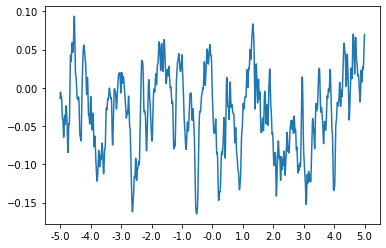

In [34]:
plt.plot(np.array(correlation_ccf["TP9"])[:,0])

plt.xticks(np.linspace(0,2561, 11),
           np.round((np.linspace(0,2561, 11)-1281)/256))
plt.show()

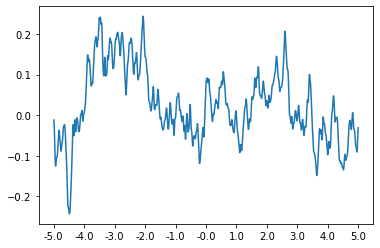

In [35]:
plt.plot(np.array(correlation_ccf["TP10"])[:,0])

plt.xticks(np.linspace(0,2561, 11),
           np.round((np.linspace(0,2561, 11)-1281)/256))
plt.show()

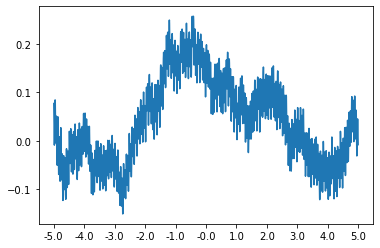

In [37]:
plt.plot(np.array(correlation_ccf["AF7"])[:,0])

plt.xticks(np.linspace(0,2561, 11),
           np.round((np.linspace(0,2561, 11)-1281)/256))
plt.show()

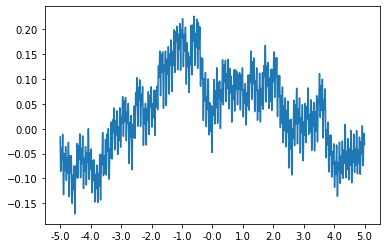

In [38]:
plt.plot(np.array(correlation_ccf["AF8"])[:,0])

plt.xticks(np.linspace(0,2561, 11),
           np.round((np.linspace(0,2561, 11)-1281)/256))
plt.show()

In [ ]:

import statsmodels.tsa.stattools as smt
def obtain_ccf(ts_1, ts_2, length=5):
    backwards = smt.ccf(ts_1[::-1], ts_2[::-1], adjusted=False)[::-1][-(length*256+1):]
    forwards = smt.ccf(ts_1, ts_2, adjusted=False)[:(length*256+1)]
    ccf_output = np.r_[backwards[:-1], forwards]
    return ccf_output

In [ ]:
corr_df_TP9 = eeg_long_df.groupby(["subj", "ses"])[["TP9-1", "TP9-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,-1]
corr_df_AF7 = eeg_long_df.groupby(["subj", "ses"])[["AF7-1", "AF7-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,-1]
corr_df_AF8 = eeg_long_df.groupby(["subj", "ses"])[["AF8-1", "AF8-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,-1]
corr_df_TP10 = eeg_long_df.groupby(["subj", "ses"])[["TP10-1", "TP10-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,-1]

corr_df = pd.concat([corr_df_TP9, corr_df_AF7, corr_df_AF8, corr_df_TP10], axis=1)
corr_df.columns = ["TP9", "AF7", "AF8", "TP10"]
corr_df["subj"] = eeg_long_df.groupby(["subj", "ses"])[["TP9-1", "TP9-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,0]
corr_df["ses"] = eeg_long_df.groupby(["subj", "ses"])[["TP9-1", "TP9-2"]].corr().iloc[0::2,-1].reset_index().iloc[:,1]

In [ ]:
dropped_time_1 = eeg_long_df[["TP9-1"]].isna().groupby([eeg_long_df["subj"], eeg_long_df["ses"]]).sum()["TP9-1"]
session_size_1 = eeg_long_df[["TP9-1"]].isna().groupby([eeg_long_df["subj"], eeg_long_df["ses"]]).size()
dropped_1 = dropped_time_1/session_size_1
dropped_time_2 = eeg_long_df[["TP9-2"]].isna().groupby([eeg_long_df["subj"], eeg_long_df["ses"]]).sum()["TP9-2"]
session_size_2 = eeg_long_df[["TP9-2"]].isna().groupby([eeg_long_df["subj"], eeg_long_df["ses"]]).size()
dropped_2 = dropped_time_2/session_size_2
dropped_time_total = eeg_long_df[["TP9-1", "TP9-2"]].isna().any(axis=1).groupby([eeg_long_df["subj"], eeg_long_df["ses"]]).sum()
dropped_total = dropped_time_total/session_size_2

In [ ]:
corr_df["dropped_1"] = dropped_1.to_list()
corr_df["dropped_2"] = dropped_2.to_list()
corr_df["dropped_total"] = dropped_total.to_list()
corr_df["timing"] = np.array(session_size_1.to_list())/256/60

In [ ]:
performance

In [ ]:
corr_df = corr_df.merge(performance, on = ["subj", "ses"], how = "left")

In [ ]:
corr_df 

In [ ]:
corr_df_old = pd.read_csv("cor_par_1_59.csv")

In [ ]:
corr_df_old[corr_df.columns]

In [ ]:
corr_df = pd.concat([corr_df_old[corr_df.columns], corr_df]).reset_index(drop=True)

In [ ]:
corr_df = corr_df.dropna()

In [ ]:
corr_df

In [ ]:
corr_df.dropped_total.hist()
plt.show()

In [ ]:
# corr_df.to_csv("corr_df_na_epoch1.csv")

In [ ]:
sns.pairplot(corr_df[["TP9", "AF7", "AF8", "TP10", "Performance", "Time (sec)", "dropped_total"]])
plt.show()

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
sns.scatterplot(data=corr_df, x="Performance", y="AF7")
plt.show()

In [ ]:
from scipy.stats import pearsonr, zscore

In [ ]:
def drop_outlier(data, variables, threth):
    temp_data = data.copy()
    temp_data = temp_data.dropna()
    temp_data_no_outlier = temp_data[(np.abs(zscore(temp_data[variables])) < threth).all(axis=1)]
    return temp_data_no_outlier

In [ ]:
def plot_scatter(data, variables, threth):
    temp_data = data.copy()
    temp_data_no_outlier = drop_outlier(temp_data, variables, threth)
    x = variables[0]
    y = variables[1]
    sns.scatterplot(temp_data_no_outlier[x], temp_data_no_outlier[y])
    print(pearsonr(temp_data_no_outlier[x], temp_data_no_outlier[y]))

In [ ]:
import statsmodels.api as sm

In [ ]:
corr_df = corr_df.dropna()

In [ ]:
corr_df

In [ ]:
corr_df_no_outlier = drop_outlier(corr_df, ["TP9", "AF7", "AF8", "TP10"], 2)

In [ ]:
corr_df_no_outlier

In [ ]:
sns.heatmap(corr_df.dropna()[["TP9", "AF7", "AF8", "TP10", "Performance", "Time (sec)"]].corr(), annot=True)
plt.show()

In [ ]:
sns.heatmap(corr_df_no_outlier[["TP9", "AF7", "AF8", "TP10", "Performance", "Time (sec)"]].corr(), annot=True)
plt.show()

In [ ]:
x = corr_df_no_outlier[["TP9", "AF7", "AF8", "TP10"]]
y = corr_df_no_outlier['Performance']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

In [ ]:
x = corr_df[["TP9", "AF7", "AF8", "TP10"]]
y = corr_df['Performance']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
corr_df.dropped_total.hist(alpha=0.5, label="total")
corr_df.dropped_1.hist(alpha=0.5, label="person 1")
corr_df.dropped_2.hist(alpha=0.5, label="person 2")
plt.legend()
plt.xlabel("Percentage of dropped epochs")
plt.show()

In [ ]:
plot_scatter(corr_df, ["Performance", "AF7"], 2)
plt.show()

In [ ]:
plot_scatter(corr_df, ["Performance", "AF8"], 2)
plt.show()

In [ ]:
plot_scatter(corr_df.iloc[10:], ["Performance", "TP9"], 2)
plt.show()

In [ ]:
plot_scatter(corr_df, ["Performance", "TP10"], 2)
plt.show()

In [ ]:
plot_scatter(corr_df.iloc[10:], ["Performance", "Time (sec)"], 2)

In [ ]:
# sns.histplot(corr_df["timing"])
sns.histplot(corr_df["dropped_2"])

In [ ]:
corr_df

In [ ]:
corr_df_filter = corr_df[(corr_df.dropped_1 <= 0.7) & (corr_df.dropped_2 <= 0.7)]

corr_df_filter = corr_df_filter[corr_df_filter.timing >= 3.5]


In [ ]:
corr_df_filter[["subj", "ses"]]

In [ ]:
# from sklearn.mixture import GaussianMixture
# gmm = GaussianMixture(n_components=2, tol=1, random_state=0).fit(corr_df_filter[["TP10", "AF7", "AF8", "TP9"]])

# labels = gmm.predict(corr_df_filter[["TP10", "AF7", "AF8", "TP9"]])
# labels.sum()

In [ ]:
labels

In [ ]:
# sns.histplot(corr_df_filter["timing"])
# plt.show()

In [ ]:
# corr_df_filter = drop_outlier(corr_df_filter, ["TP9", "AF7", "AF8", "TP10"], 3)

In [ ]:
# sns.pairplot(corr_df_filter[["TP9", "AF7", "AF8", "TP10", "Performance", "Time (sec)", "dropped_total"]])
# plt.show()

In [ ]:
corr_df_filter.shape

In [ ]:
x = corr_df_filter[["TP9", "AF7", "AF8", "TP10", "ses", "Time (sec)"]]
y = corr_df_filter['Performance']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

In [ ]:
sns.heatmap(corr_df_filter[["TP9", "AF7", "AF8", "TP10", "Performance", "Time (sec)"]].corr(), annot=True)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
corr_df_filter.subj.unique().shape

In [ ]:
sns.boxplot(x = corr_df_filter.ses, y = corr_df_filter["Performance"])
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(8,8))

channels = ["TP9", "AF7", "AF8", "TP10"]
for i in range(4):
    sns.boxplot(x = corr_df_filter.ses, y = corr_df_filter[channels[i]], ax=axs[i//2, i%2])

plt.show()

In [ ]:
import statsmodels.api as sm

from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

In [ ]:
channels = ["AF8", "AF7", "TP10", "TP9", "Performance"]
for channel in channels:
    l_model = ols('{} ~ C(ses)'.format(channel),
                 data=corr_df_filter.dropna()).fit()
    table = sm.stats.anova_lm(l_model) # Type 2 ANOVA DataFrame
    print("=========================== AVNOVA Table ========================")
    print("================= {} ~ Session ====================". format(channel))
    print(table)

In [ ]:
from statsmodels.multivariate.manova import MANOVA

In [ ]:
maov = MANOVA.from_formula(' AF8 + AF7 + TP10 + TP9 ~ C(ses)', data=corr_df_filter)

In [ ]:
print(maov.mv_test())

In [ ]:
x = corr_df_filter.dropna()[["TP9", "AF7", "AF8", "TP10", "ses", "Time (sec)"]]
y = corr_df_filter.dropna()['Performance']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

In [ ]:
corr_df_filter.subj.unique().shape

In [ ]:
sns.regplot(y="Performance", x="AF8", data=corr_df_filter)
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.boxplot(x = corr_df_filter.ses, y = corr_df_filter["Performance"], ax=ax[0])
sns.regplot(y="Performance", x="AF8", data=corr_df_filter, ax=ax[1])

# ax[0].set_title("Title",fontsize=50)
ax[0].set_xlabel("Session",fontsize=20)
ax[0].set_ylabel("Performance",fontsize=20)

ax[1].set_xlabel("AF8",fontsize=20)
ax[1].set_ylabel("Performance",fontsize=20)

ax[0].annotate("A", fontsize= 30, xy=(-0.15, 0.95), xycoords="axes fraction")
ax[1].annotate("B", fontsize= 30, xy=(-0.15, 0.95), xycoords="axes fraction")

plt.show()

In [ ]:
l_model = ols('Performance ~ C(ses) + AF8 + C(ses)*AF8', data=corr_df_filter).fit()
table = sm.stats.anova_lm(l_model) # Type 2 ANOVA DataFrame
print(table)

In [ ]:
print(l_model.summary())